In [16]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path

In [1]:
from fastai import *
from fastai.vision import *
from fastai.vision.data import ObjectCategoryProcessor   
from fastai.layers import *
from fastai.callbacks.hooks import num_features_model
from fastai.callbacks.mixup import *     
from torch.nn import L1Loss
from metrics import *

In [2]:
path = Path('/data/Datasets/WhiteBloodCancer/train/')

In [3]:
images, lbl_bbox = get_annotations(path/'WhiteBloodCellCoco.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [4]:
class BloodCellObjectCategoryProcessor(ObjectCategoryProcessor):                 
                                                                                 
    def generate_classes(self, items):                                           
        "Generate classes from `items` by taking the sorted unique values."      
        classes = set()                                                          
        for c in items: classes = classes.union(set(c[1]))                       
        classes = list(classes)                                                  
        classes.sort()                                                           
        return classes                                                           

In [5]:
class BloodCellObjectCategoryList(ObjectCategoryList):
    _processor = BloodCellObjectCategoryProcessor  
    
    def analyze_pred(self, pred):
        return [pred[0], pred[1].max(0)[1]]
    
    def reconstruct(self, t, x):
        (bboxes, labels) = t
        #if len((labels - self.pad_idx).nonzero()) == 0: return
        if labels.ndim == 0: labels = labels.view(-1)
        i = 0
        bboxes,labels = bboxes[i:],labels[i:]
        return ImageBBox.create(*x.size, bboxes, labels=labels, classes=self.classes, scale=False)

In [6]:
data = (ObjectItemList.from_folder(path, extensions='.bmp')
        #Where are the images? -> in coco
        .random_split_by_pct(0.1)
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func, label_cls=BloodCellObjectCategoryList)
        #How to find the labels? -> use get_y_func
        .transform(get_transforms(), tfm_y=True, size=384)
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=128, collate_fn=bb_pad_collate))
        #Finally we convert to a DataBunch and we use bb_pad_collate

In [7]:
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(25,25))

In [8]:
class CellFinder(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__()
        self.cnn = create_body(arch)
        self.box_regressor = create_head(num_features_model(self.cnn) * 2, 4)
        self.classifier = create_head(num_features_model(self.cnn) * 2, 2)

    def forward(self, im):
        x = self.cnn(im)
        box = self.box_regressor(x)
        classifier = self.classifier(x)

        return [(2 * (box.sigmoid_() - 0.5)).view(-1, 1, 4), classifier]

In [9]:
class CombinedLoss(nn.Module):

    def forward(self, output, bbox_tgts, clas_tgts):
        bbox_preds, clas_preds = output

        self.loss1 = L1Loss()(bbox_preds, bbox_tgts.squeeze())
        self.loss2 = CrossEntropyFlat()(clas_preds, clas_tgts)
        return self.loss1 + self.loss2

In [10]:
class HandleDualLoss(LearnerCallback):
    _order = -20 #Needs to run before the recorder
    
    def on_train_begin(self, **kwargs):
        self.learn.recorder.add_metric_names(['bb_loss', 'c_loss'])
    
    def on_epoch_begin(self, **kwargs):
        self.bb_loss, self.c_loss, self.nums = 0., 0., 0
    
    def on_batch_end(self, last_target, train, **kwargs):
        if not train:
            bs = last_target[0].size(0)
            self.bb_loss += bs * learn.loss_func.loss1.detach()
            self.c_loss += bs * learn.loss_func.loss2.detach()
            self.nums += bs
    
    def on_epoch_end(self, **kwargs):
        self.learn.recorder.add_metrics([self.bb_loss/self.nums, self.c_loss/self.nums])

In [26]:
class ShowImageWithGraph(LearnerCallback):
    
    def __init__(self, learn:Learner):
        super().__init__(learn)

        self.images = []
        self.titles = []
        
    "Update a graph of learner stats and metrics after each epoch."
    def on_epoch_end(self, n_epochs:int, last_metrics:MetricsList, last_input, last_output, last_target, pbar, **kwargs)->bool:
        "If we have `last_metrics` plot them in our pbar graph"
        rec = self.learn.recorder
        if last_metrics is not None:
            iters = range_of(rec.losses)
            val_iter = np.array(rec.nb_batches).cumsum()
            x_bounds = (0, (n_epochs - len(rec.nb_batches)) * rec.nb_batches[-1] + len(rec.losses))
            y_bounds = (0, max((max(Tensor(rec.losses)), max(Tensor(rec.val_losses)))))
            #rec.pbar.update_graph([(iters, rec.losses), (val_iter, rec.val_losses)], x_bounds, y_bounds)

        data = self.learn.data
        
        image = data.train_ds.x.reconstruct(last_input[0])

        self.titles.append('Epoch {}'.format(kwargs['epoch']))
        self.images.append(image)

        pbar.show_imgs(self.images, self.titles)

In [27]:
def iou_metric(output, bbox_tgts, clas_tgts):
    bbox_preds, clas_preds = output
    return IoU(bbox_tgts.squeeze(), bbox_preds.squeeze()).mean()

def error_rate(output, bbox_tgts, clas_tgts)->Rank0Tensor:
    "1 - `accuracy`"
    bbox_preds, clas_preds = output
    return 1 - accuracy(clas_preds, clas_tgts[:,:2].long())

In [28]:
learn = Learner(data, CellFinder(arch=models.resnet18), loss_func=CombinedLoss(), callback_fns=[ShowImageWithGraph, HandleDualLoss])
learn.metrics = [iou_metric, error_rate, F1Weighted(), MCC()]

learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.box_regressor, learn.model.classifier])

In [29]:
learn.freeze_to(-2)

epoch,train_loss,valid_loss,iou_metric,error_rate,f1_weighted,mcc,bb_loss,c_loss
1,0.778457,0.602661,0.474533,0.157598,0.851293,0.000000,0.228431,0.374230
2,0.501424,0.403190,0.740752,0.126642,0.865354,0.000000,0.078779,0.324412
3,0.412910,0.694375,0.726252,0.231707,0.941935,0.000000,0.088278,0.606097


/home/c.marzahl@de.eu.local/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/c.marzahl@de.eu.local/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


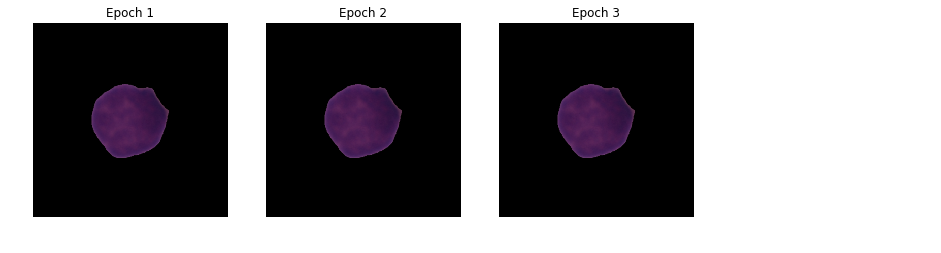

KeyboardInterrupt: 

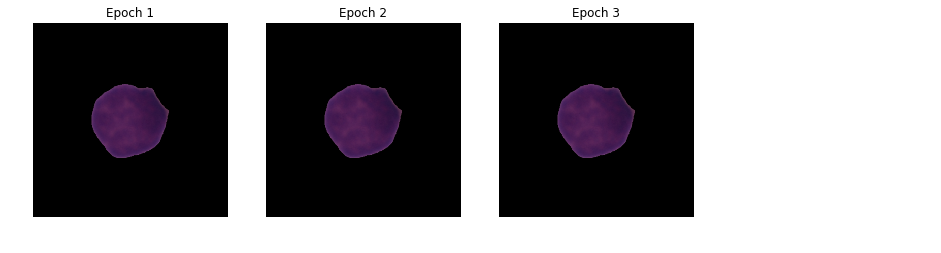

In [30]:
learn.fit_one_cycle(10, 1e-2)

In [17]:
learn.unfreeze()

In [18]:
max_lr = 2e-3
lrs = [max_lr/100, max_lr/10, max_lr, max_lr]

epoch,train_loss,valid_loss,iou_metric,error_rate,f1_weighted,mcc,bb_loss,c_loss
1,0.242601,0.207874,0.738461,0.048780,0.950975,0.890293,0.076225,0.131649
2,0.251707,0.302003,0.731689,0.082552,0.915542,0.814233,0.078514,0.223489
3,0.262444,0.269402,0.743407,0.082552,0.916715,0.813456,0.075648,0.193754
4,0.252314,0.217095,0.727674,0.049719,0.949526,0.888966,0.081854,0.135240
5,0.237847,0.233538,0.728004,0.061914,0.938653,0.866008,0.081004,0.152534
6,0.230575,0.229893,0.734472,0.054409,0.944882,0.877828,0.077881,0.152013
7,0.211257,0.221387,0.745340,0.051595,0.947482,0.885219,0.073806,0.147581
8,0.196316,0.173490,0.732964,0.035647,0.964036,0.920192,0.078823,0.094667
9,0.183657,0.163887,0.733240,0.030019,0.969738,0.932896,0.078506,0.085381
10,0.174901,0.160433,0.733885,0.030957,0.968805,0.930721,0.078024,0.082409


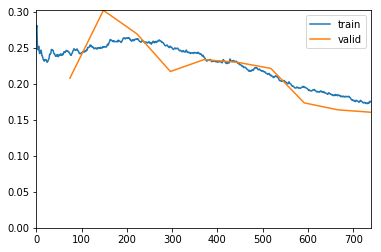

In [19]:
learn.fit_one_cycle(10, lrs)#, div_factor=20

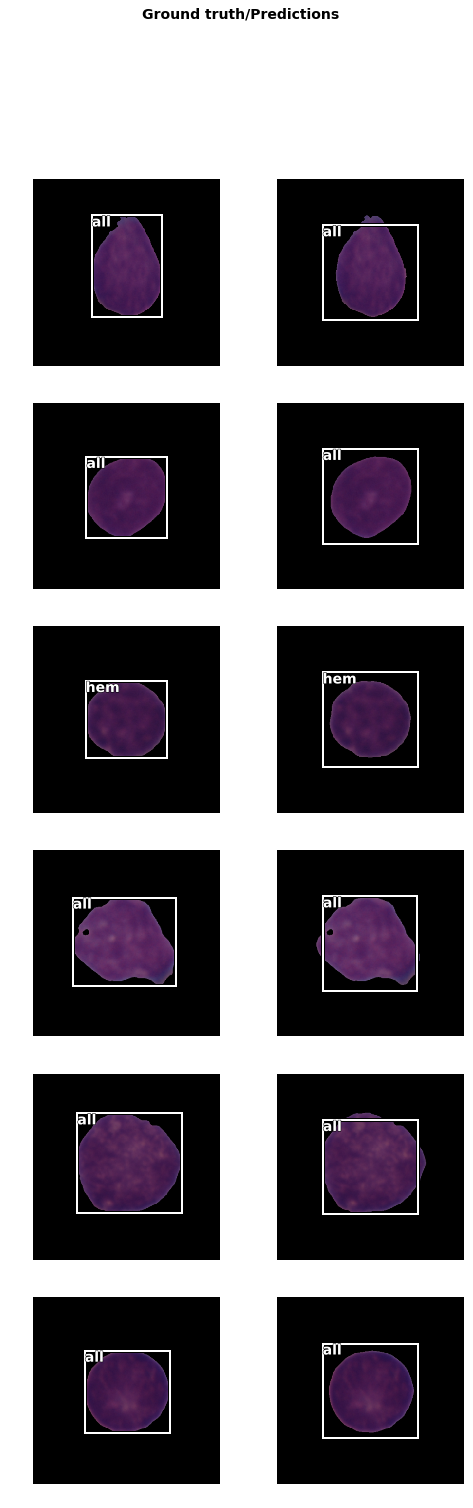

In [20]:
learn.show_results(rows=6)